# Homework 1

In this homework you will be implementing the followings:
- Modeling an MDP             **(30)**
- Dynamic programming methods **(20)**
- Tabular Methods             **(20)**
- Approximate Methods         **(30)**

This notebook is like an interface of your implementations, you can visualize and observe your agents and your MDP. You can still change some of the cells below in order to experiment with your implementations but remember that you don't need to modify this notebook.

## 1. Modeling your MDP
In this section of the homework, you will be implementing an MDP for the given dynamics of the environment. You need to code the missing part of the gridworld module in the env folder. In order to model the MDP, you are being asked to construct a transition table(transition_map) for the MDP that keeps the transition probabilities, reward values and terminations for each neighbor of all the reachable states.


```
transition_map[state][action] -> [(probability, neighboor_state, reward, termination), ...]

```

### MDP

- Any tile on the grid has four adjacent tiles if it is not at the border.
- From all the reachable states(none wall tiles) it is only allowed to transition to its neighbour states(adjacent tiles) or itself.
- In a reachable tile, an agent is expected to transition to its targeted tile by the given action with 0.95 probability and all the other neighbour tiles with the 0.05 probability(uniformly).
- If a tile has a termination equals to 1, the episode is expected to be finished.
- Reward and termination values are given for all the tile types so you don't need to define them.

You may want to check out some of the [gym environments](https://github.com/openai/gym/tree/master/gym/envs/toy_text) for help.

In [ ]:
# In order to use modified modules without restarting
%load_ext autoreload
%autoreload 2

#### Grid World (Random agent)

In [1]:
from blg604ehw1 import GridWorldEnv
import random
import time
env = GridWorldEnv()
eps = 0
iteration = 0
for i in range(100):
    state, reward, done, info = env.step(random.randint(0, 3))
    iteration += 1
    env.render(mode="notebook", info="Episode: {}, Step: {}".format(eps, iteration))
    if done:
        env.reset()
        eps += 1
        iteration = 0
env.renderer.animate("js")

## 2. Dynamic Programming Methods

Now, you have an MDP whose transition and reward functions are known, you can start optimizing your agent. For this instance, you will be implementing dynamic programming methods namely Policy Iteration and Value Iteration.
Then you can visualize your agents.

In [2]:
from blg604ehw1 import GridWorldEnv
from blg604ehw1 import PolicyIteration
from blg604ehw1 import ValueIteration

def train_dp(agent, env):
    agent.optimize(gamma=1.0, epsilon=0.001)
    done = False
    state = env.reset()
    while (not done):
        act = agent.policy(state)
        state, reward, done, _ = env.step(act)
        env.render(mode="notebook")
    return env.renderer.animate("js")

Policy Iteration

In [3]:
train_dp(PolicyIteration(env.nA, env.nS, env.P), GridWorldEnv())

#### Value Iteration

In [4]:
train_dp(ValueIteration(env.nA, env.nS, env.P), GridWorldEnv())

## 3. Tabular Methods

What if you don't know the transition function or the reward function of the MDP. This is generally the case for most of the environments. This is where you need to optimize your agents via sampling or simply exploring the environment.

In this section, you will be implementing tabular Q learning and Sarsa methods to optimally control your agents in the same gridworld environment. You can also visualize the learning process and observe how the value propagates through the adjacent states.

In [ ]:
from collections import namedtuple
from blg604ehw1 import QAgent
from blg604ehw1 import SarsaAgent
from blg604ehw1 import GridWorldEnv

QTransition = namedtuple("QTransition", "state action reward next_state terminal")
SarsaTransition = namedtuple("SarsaTransition", "state action reward next_state next_action terminal")

In [ ]:
EPSILON = 0.2
ALPHA = 0.5
EPISODES = 100
MAX_LEN = 200
GAMMA = 0.99

def iter_episode(env, agent, test=False):
    eps_reward = 0.0
    policy = agent.greedy_policy if test else agent.soft_policy
    state = env.reset()
    action = policy(state)
    td_error = 0
    for i in range(MAX_LEN):       
        next_state, reward, done, _ = env.step(action)
        next_action = policy(next_state)
        if isinstance(agent, QAgent):
            transition = QTransition(state, action, reward, next_state, done)
        elif isinstance(agent, SarsaAgent):
            transition = SarsaTransition(state, action, reward, next_state, next_action, done)
        if not test:
            td_error += agent.update(transition, ALPHA, GAMMA)
        eps_reward += reward
        state = next_state
        action = next_action
        if done:
            break
            
    episode_length = i
    return episode_length, eps_reward, abs(td_error)

In [ ]:
def visualize_test(env, agent):
    env.renderer.reset_buffer()
    eps_reward = 0.0
    state = env.reset()
    for i in range(MAX_LEN):
        action = agent.greedy_policy(state)
        state, reward, done, _ = env.step(action)
        env.render(mode="notebook")
        eps_reward += reward
        if done:
            break
            
    episode_length = i
    return episode_length, eps_reward, 0

In [ ]:
def train(agent, env):
    _, _, td = iter_episode(agent, env, test=False)
    eps_length, eps_reward, _ = iter_episode(agent, env, test=True)
    return eps_reward, eps_length, float(td)

#### Training

In [ ]:
REPEAT = 25
q_logs = [[train(env, agent) for i in range(EPISODES)] for env, agent in [(GridWorldEnv(), QAgent(4))]*REPEAT]
sarsa_logs = [[train(env, agent) for i in range(EPISODES)] for env, agent in [(GridWorldEnv(), SarsaAgent(4))]*REPEAT]

#### Agent Comparison
**Note:** You may want to rerun the cell below if plots are mixed together.

In [ ]:
from blg604ehw1 import comparison
plot_texts = [
    [
        "Episodic Reward",
        "episode",
        "reward"
    ],
    [
        "Episode Length",
        "episode",
        "length"
    ],
    [
        "Td Error",
        "episode",
        "td"
    ]
]
comparison((q_logs, "Q agent"), (sarsa_logs, "Sarsa agent"), texts=plot_texts)

#### Greedy Policy After Training

In [ ]:
#agent = QAgent(4)
agent = SarsaAgent(4)
env = GridWorldEnv()
[train(env, agent) for i in range(EPISODES)]
visualize_test(env, agent)
env.renderer.animate()

####  What's under the hood?

In [ ]:
from copy import deepcopy
from collections import defaultdict
import numpy as np 
agent = QAgent(4)
#agent= SarsaAgent(4)
env = GridWorldEnv()
value_buffer = []
for i in range(EPISODES*2):
    iter_episode(env, agent)
    value_buffer.append(deepcopy(agent.values))
    
env.renderer.analysis(value_buffer)

## 4. Approximate Methods
When the state space is too large or it's continuous it becomes difficult to use tabular methods. This is where approximation can be handy. In this section, you will be implementing approximate Q learning, approximate Sarsa and least-square temporal difference method where the value function is approximated with a linear function or with a linear combination of RBFs on the Cart Pole environment. The objective of the environment is to balance the rod by moving the cart along the x-axis.

In [1]:
import gym
import numpy as np
from blg604ehw1 import animater

### Cart Pole (Random agent)

In [2]:
import warnings
with warnings.catch_warnings():      # To catch a simple warning from gym
    warnings.simplefilter("ignore")
    
    env = gym.make("CartPole-v1")
    env.reset()
    buffer = []
    for i in range(60):
        env.step(env.action_space.sample())
        buffer.append(env.render(mode='rgb_array'))
    env.close()    
animater(buffer)

### Approximate Q Learning and Sarsa(Semi-gradient Methods)
When we approximate the value function one way to optimize the Bellman equation is via Gradient Descent. Yet, as you may remember we don't want to change the target value when optimizing the equation. However, when we take the gradient with respect to parameters it's no longer the case. That's why we only take the gradient with respect to predicted value's parameters and therefore it's also called Semi-Gradient Method.

You will be implementing Sarsa and Q Learning in approximate settings.

In [3]:
from blg604ehw1 import ApproximateSarsaAgent
from blg604ehw1 import ApproximateQAgent
from collections import namedtuple
from copy import deepcopy

QTransition = namedtuple("QTransition", "state action reward next_state terminal")
SarsaTransition = namedtuple("SarsaTransition", "state action reward next_state next_action terminal")

ALPHA = 0.01
EPISODES = 200
MAX_LEN = 200
GAMMA = 0.99

def iter_episode(env, agent, test=False, iteration=None):
    eps_reward = 0.0
    td_error = 0
    iteration = iteration or 1
    policy = agent.greedy_policy if test else lambda s: agent.e_greedy_policy(s, 0.9/(iteration+1)+0.05)
    state = env.reset()
    action = policy(state)
    for i in range(MAX_LEN):
        next_state, reward, done, _ = env.step(action)
        next_action = policy(state)
        if isinstance(agent, ApproximateQAgent):
            transition = QTransition(state, action, reward, next_state, done)
        elif isinstance(agent, ApproximateSarsaAgent):
            transition = SarsaTransition(state, action, reward, next_state, next_action, done)
        if not test:
            td_error += agent.update(transition, ALPHA, GAMMA)
        eps_reward += reward
        state = next_state
        action = next_action
        if done:
            break
            
    episode_length = i
    return episode_length, eps_reward, abs(td_error)

**Checkpoints** are important when you are dealing with approximate methods. You can keep the best agent by comparing agents test rewards.

In [4]:
Checkpoint = namedtuple("Checkpoint", "agent, avg_reward")
checkpoint = Checkpoint(None, 0)
def train(env, agent, i):
    global checkpoint
    _, _, td = iter_episode(env, agent, test=False, iteration=i)
    avg_reward = sum(iter_episode(env, agent, test=True)[1] for i in range(5))/5
    if checkpoint.avg_reward < avg_reward:
        checkpoint = Checkpoint(deepcopy(agent), avg_reward)
    return checkpoint.avg_reward, avg_reward, td  # In CartPole reward is the length

#### Training
**NOTE**: You may need to train your agents many times until they learn! Approximate methods are not guaranteed to converge and sometimes they diverge! Remember, the maximum reward is the Episode length (MAX_LEN).

In [15]:
REPEAT = 50
q_logs = [[train(env, agent, i) for i in range(EPISODES)] 
          for env, agent in [(gym.make("CartPole-v1"), ApproximateQAgent(4, 2))]*REPEAT]
q_checkpoint = checkpoint
checkpoint = Checkpoint(None, 0)
sarsa_logs = [[train(env, agent, i) for i in range(EPISODES)] 
              for env, agent in [(gym.make("CartPole-v1"), ApproximateSarsaAgent(4, 2))]*REPEAT]
sarsa_checkpoint = checkpoint

#### Comparison

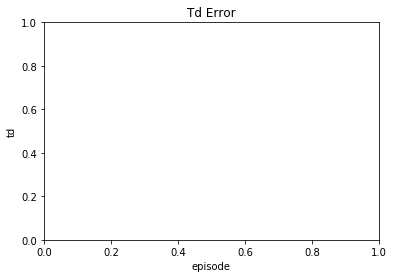

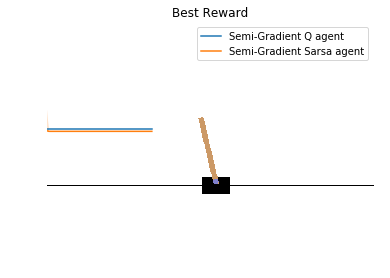

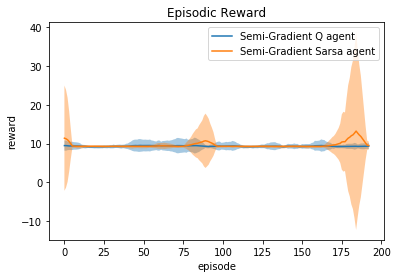

ValueError: x and y can be no greater than 2-D, but have shapes (193,) and (193, 4, 2)

In [16]:
from blg604ehw1 import comparison
plot_texts = [
    
    [
        "Best Reward",
        "episode",
        "reward"
    ],
    [
        "Episodic Reward",
        "episode",
        "reward"
    ],
    [
        "Td Error",
        "episode",
        "td"
    ]
]
comparison((q_logs, "Semi-Gradient Q agent"), (sarsa_logs, "Semi-Gradient Sarsa agent"), texts=plot_texts)

In [18]:
def visualize_test(env, agent):
    eps_reward = 0.0
    state = env.reset()
    buffer = []
    for i in range(MAX_LEN):
        action = agent.greedy_policy(state)
        state, reward, done, _ = env.step(action)
        buffer.append(env.render(mode='rgb_array'))
        eps_reward += reward
        if done:
            break
            
    episode_length = i
    env.close()
    return buffer
buffer = visualize_test(gym.make("CartPole-v1"), q_checkpoint.agent)
print("Max reward: {}, current best: {}".format(MAX_LEN, q_checkpoint.avg_reward))
animater(buffer)
buffer = visualize_test(gym.make("CartPole-v1"), sarsa_checkpoint.agent)
print("Max reward: {}, current best: {}".format(MAX_LEN, sarsa_checkpoint.avg_reward))
animater(buffer)

Max reward: 200, current best: 196.0
Max reward: 200, current best: 200.0


When we approximate the value function things get messy. One of the reason is Bootstrapping. Its also known as "guess from a guess". You actually used it before when you implemented q learning and sarsa(named after "state action reward state' action' "). In the Bellman equation when you use your not yet converged values as the target value, it is bootstrapping. TD uses bootstrapping to update the values at every step rather than the end of an episode. In tabular settings this is quite handy, however, there is a caveat when using it in the approximate settings.

$ TD_{error} \leftarrow (R +  max_{a}V(s', a)\gamma - V(s, a))^2$

Since the value function is parameterized with a parameter vector when you update it, both the predicted value and the target value will be changed while the target should not be changed. This means you won't be able to trap the reward as easily as in the tabular settings.


### Least-Square Temporal Difference (LSTDQ)
Instead of iteratively updating the values you can find the best fitting approximation in one step when you are using a linear approximation. LSTD methods are exactly doing this. In this subsection, you will be implementing LSTDQ method and you will be training it in the same environment.

In [56]:
from blg604ehw1 import LSTDQ

QTransition = namedtuple("QTransition", "state action reward next_state terminal")
SARSATransition = namedtuple("SARSATransition", "state action reward next_state next_action terminal")

EPISODES = 1000
MAX_LEN = 200
GAMMA = 1
MEMORY_LENGTH = 200
RBF_KERNELS = 50
REPEAT = 10

checkpoint = Checkpoint(None, 0)

def test_one_episode(env ,agent):
    eps_reward = 0.0
    policy = agent.greedy_policy
    state = env.reset()
    for i in range(MAX_LEN):
        action = policy(state)
        state, reward, done, info = env.step(action)
        eps_reward += reward
        if done:
            break
    return eps_reward

def train(env, agent, test=False):
    global checkpoint
    trajectory = []
    rewards = []
    avg_reward = 0
    for iteration in range(EPISODES):
        policy = lambda s: agent.e_greedy_policy(s, 0.9/(iteration+1)+0.05)
        state = env.reset()
        for i in range(MAX_LEN):
            action = policy(state)
            next_state, reward, done, _ = env.step(action) 
            next_action = policy(next_state)
            transition = SARSATransition(state, action, reward, next_state, next_action, done)
            trajectory.append(transition)
            state = next_state
            if done:
                break
        rewards.append((avg_reward, checkpoint.avg_reward))
        
        if len(trajectory) > MEMORY_LENGTH:
            agent.optimize(trajectory, GAMMA)
            trajectory = []
            avg_reward = sum(test_one_episode(env, agent) for i in range(5))/5
             
            if checkpoint.avg_reward < avg_reward:
                checkpoint = Checkpoint(deepcopy(agent), avg_reward)
            
    episode_length = i
    return rewards

#### Training

In [57]:
lstdq_log = [train(env, agent) for env, agent in [(gym.make("CartPole-v1"), LSTDQ(4, 2, RBF_KERNELS))]*REPEAT]

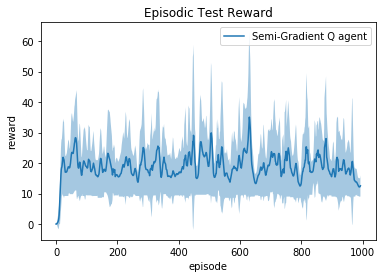

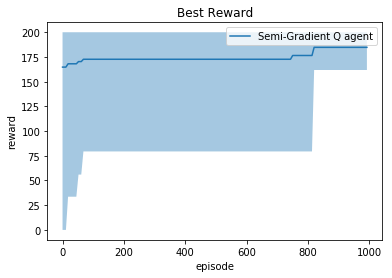

In [58]:
from blg604ehw1 import comparison
plot_texts = [
    [
        "Episodic Test Reward",
        "episode",
        "reward"
    ],
    [
        "Best Reward",
        "episode",
        "reward"
    ]
]
comparison((lstdq_log, "Semi-Gradient Q agent"), texts=plot_texts)

#### Visualize the agent after training

In [59]:
buffer = visualize_test(gym.make("CartPole-v1"), checkpoint.agent)
print("Max reward: {}, current best: {}".format(MAX_LEN, checkpoint.avg_reward))
animater(buffer)

Max reward: 200, current best: 200.0


In [1]:
from collections import defaultdict
nact = 1
values = defaultdict(lambda: [0.1]*nact)
print(values[1][0])

print(max(range(nact), key = lambda act: values[state][act]))
#(range(nact), key = lambda act: values[state][act])

NameError: name 'state' is not defined